In [1]:
import sim
import util
from IPython.display import clear_output
from models import GibbsSLDA, GibbsLDA

clear_output()

## Synthetic Data

In [2]:
import numpy as np

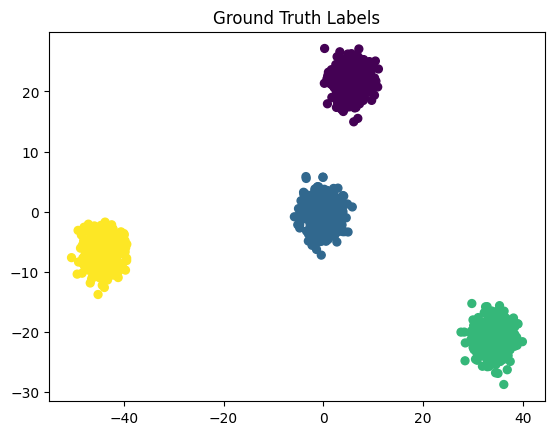

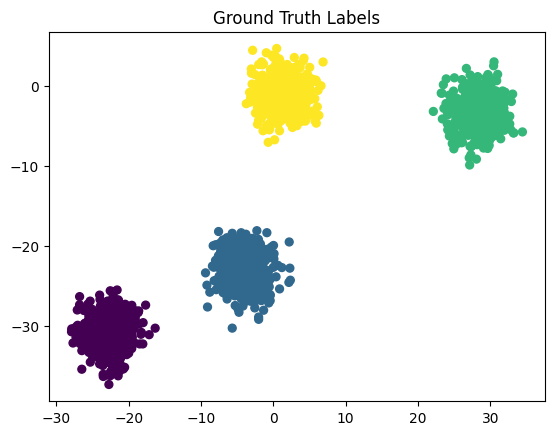

In [65]:
N_SAMPLES = 2000
N_FEATURES = 1000
N_TOPICS = 4
SCALE = 2
SHUFFLE = False
N_IMGS = 2

# means = sim.generate_means(N_FEATURES, N_TOPICS)
means = None
X = np.zeros((N_IMGS*N_SAMPLES, N_FEATURES))
X_labels = np.zeros(N_IMGS*N_SAMPLES, dtype=np.int32)
for i in range(N_IMGS):
    Y, Y_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, means, SHUFFLE)
    Y_labels += i*N_TOPICS
    X[i*N_SAMPLES:(i+1)*N_SAMPLES], X_labels[i*N_SAMPLES:(i+1)*N_SAMPLES] = Y, Y_labels
    util.visualize_data(Y, Y_labels, 'Ground Truth Labels')

img_idx = np.ones((N_IMGS*N_SAMPLES, 1))
img_idx[N_SAMPLES:2*N_SAMPLES] = 2
# img_idx[2*N_SAMPLES:] = 3
X = np.concatenate([img_idx, X], -1)

# X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, None, SHUFFLE)
# util.visualize_data(X, X_labels, 'Ground Truth Labels')

100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


Score: 1.0


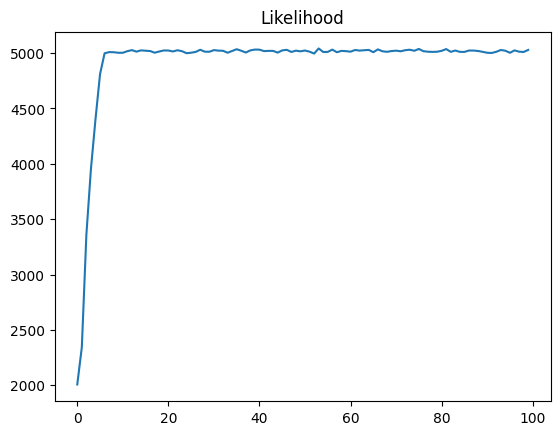

In [67]:
N_STEPS = 100
N_DOCS = 300
VOCAB_SIZE = 25
SIGMA = .1

model = GibbsSLDA(N_IMGS*N_TOPICS, N_DOCS, VOCAB_SIZE, sigma=SIGMA)
labels = model.fit_transform(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
# util.visualize_data(X[:, 1:3], Y_labels, 'Predicted Labels')
util.visualize_log(model.likelihood_log_, 'Likelihood')

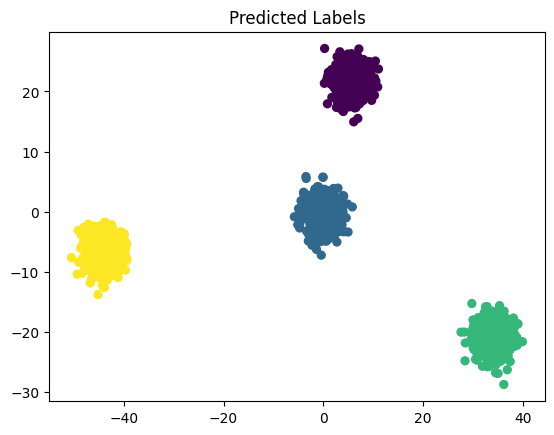

In [68]:
util.visualize_data(X[:N_SAMPLES, 1:3], Y_labels[:N_SAMPLES], 'Predicted Labels')

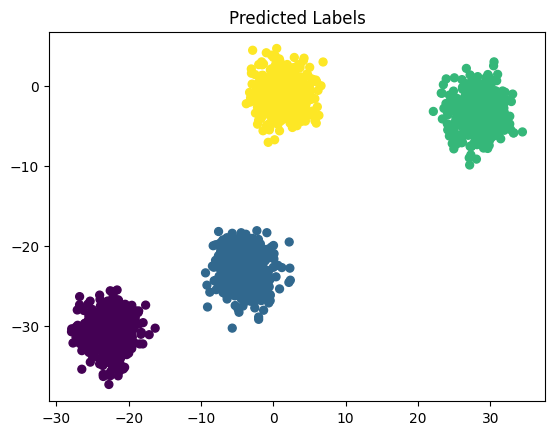

In [69]:
util.visualize_data(X[N_SAMPLES:, 1:3], Y_labels[N_SAMPLES:], 'Predicted Labels')

## Spine Data

In [2]:
import muon as mu
import numpy as np
from sklearn.neighbors import NearestNeighbors

def remove_lonely(data, labels, threshold=225., n_neighbors=12):
    locs = data[:, :2]
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(locs)
    max_dist = knn.kneighbors()[0].max(-1)
    remove_idx, = np.where(max_dist > threshold)
    data = np.delete(data, remove_idx, axis=0)
    labels = np.delete(labels, remove_idx, axis=0)
    return data, labels

def read_spine_data(filename, threshold=225., n_neighbors=12, feature_key='protein', id_key='protein:celltype'):
    mdata = mu.read(filename)
    x, y = mdata['physical'].obsm['spatial'].T
    features = mdata[feature_key].X
    data = np.concatenate([x[None].T, y[None].T, features], -1)
    ids = mdata.obs[id_key]
    labels = np.unique(ids, return_inverse=True)[1]
    if threshold is not None:
        data, labels = remove_lonely(data, labels, threshold, n_neighbors)
    return data, labels

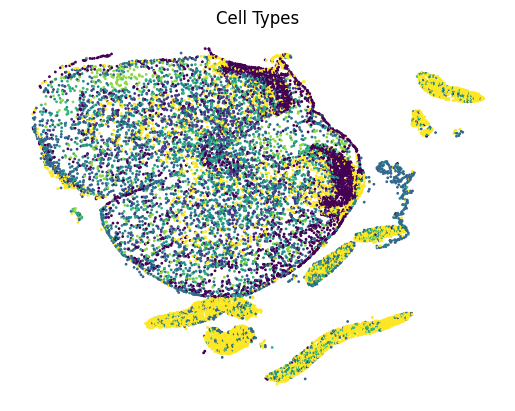

In [3]:
X, X_labels = read_spine_data('data/m387ntga2.h5mu')
clear_output()
util.visualize_data(X, X_labels, 'Cell Types', size=1, show_ax=False)

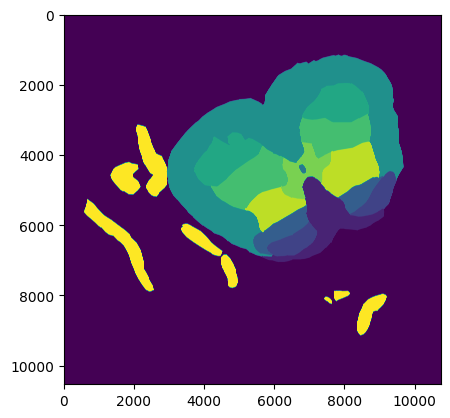

In [4]:
from skimage import io
import matplotlib.pyplot as plt

img = io.imread('data/m387ntga2.tiff').astype(np.int32)
plt.imshow(img);

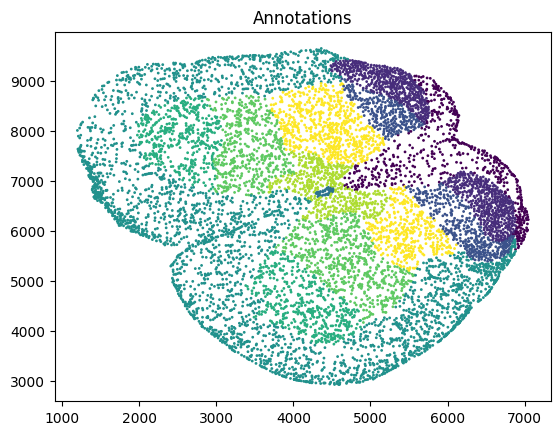

In [5]:
from scipy import ndimage
from skimage.segmentation import watershed

distance = ndimage.distance_transform_edt(img)
labels = watershed(-distance, 2, mask=img)
X_labels = np.zeros_like(X_labels)
for i in range(X_labels.shape[0]):
    x, y = int(X[i, 0]), int(X[i, 1])
    val = labels[x, y]
    if val > 0:
        X_labels[i] = img[x, y]
X = np.delete(X, np.where(X_labels == 0), 0)
X_labels = np.delete(X_labels, np.where(X_labels == 0), 0)
util.visualize_data(X, X_labels, 'Annotations', size=1)

#### Gibbs LDA

In [6]:
N_STEPS = 100

n_topics = np.unique(X_labels).shape[0]
gibbs_lda = GibbsLDA(n_topics).fit(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, gibbs_lda.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels', size=1)
util.visualize_log(gibbs_lda.likelihood_log_, 'Likelihood')

 10%|█         | 10/100 [00:30<04:38,  3.10s/it]


KeyboardInterrupt: 

#### Gibbs SLDA

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Score: 0.44344866704481


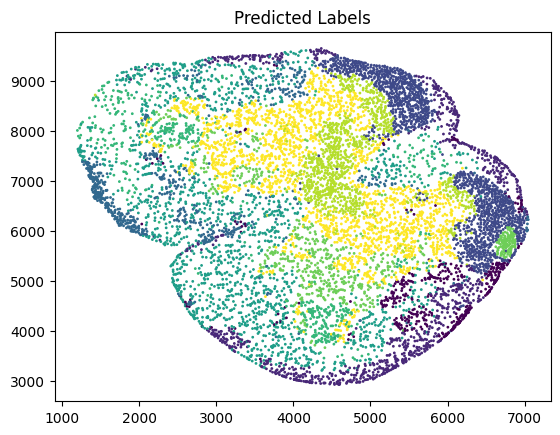

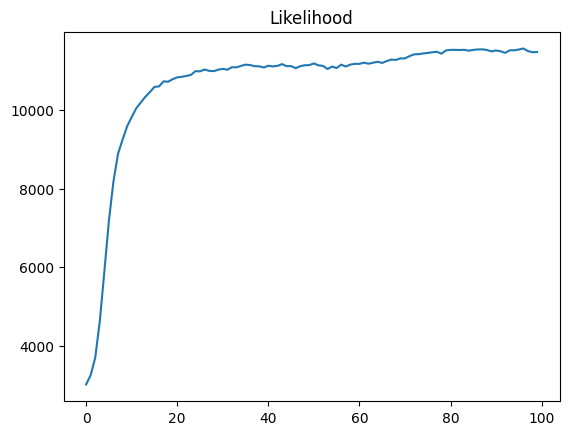

In [6]:
N_TOPICS = 9
N_DOCS = 150
VOCAB_SIZE = 50
SIGMA = 150.
N_STEPS = 100

model = GibbsSLDA(N_TOPICS, N_DOCS, VOCAB_SIZE, sigma=SIGMA)
labels = model.fit_transform(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels', size=1)
util.visualize_log(model.likelihood_log_, 'Likelihood')